In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
# U-Net Model


In [3]:

def visualize_segmentation(original_image, ground_truth, predicted_mask):
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [4]:
def iou_score(true_mask, pred_mask):
    intersection = (true_mask & pred_mask).sum()
    union = (true_mask | pred_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

In [5]:
def dice_coefficient(true_mask, pred_mask):
    intersection = (true_mask & pred_mask).sum()
    dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum()) if true_mask.sum() + pred_mask.sum() != 0 else 0
    return dice

In [6]:
def pixel_accuracy(true_mask, pred_mask):
    correct = (true_mask == pred_mask).sum()
    total = true_mask.size
    accuracy = correct / total
    return accuracy

In [7]:
def plotloss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

# Evaluate Step

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = CBR(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return torch.sigmoid(self.final_conv(dec1))

# Custom Dataset
class YUCARSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx])  # Assuming masks have the same name as images
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Assuming mask is a grayscale image

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


## Load & set mode

In [9]:
model = UNet()
model.load_state_dict(torch.load('weights/oxford_pet_200.pth'))  
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
  

## Single Evaluate

In [21]:

# Assuming test image and ground truth are stored as .png or .jpg files
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size expected by U-Net
    transforms.ToTensor()           # Convert image to PyTorch tensor
])

# Load test image and ground truth mask
#img_path = "datasets/yucars_project/Hokkaido_UNet/train/masks/tile_114.png" 
test_image = Image.open('datasets/yucars_project/Hokkaido_UNet/test/sar_img/tile_114.png').convert('RGB')  # Replace with your image path
test_mask = Image.open('datasets/yucars_project/Hokkaido_UNet/test/masks/tile_114.png').convert('L')      # Ground truth mask (binary or multi-class)

# Transform images
test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension
test_mask_tensor = transform(test_mask).squeeze(0)  # No batch dimension needed for mask


In [24]:
# Move tensor to the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_image_tensor = test_image_tensor.to(device)

# Make predictions
with torch.no_grad():
    predicted_mask = model(test_image_tensor)

# Convert predicted mask back to a format suitable for visualization
predicted_mask = torch.sigmoid(predicted_mask)  # Apply sigmoid to get probability map for binary segmentation
predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch and move to CPU for numpy
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Apply threshold for binary mask

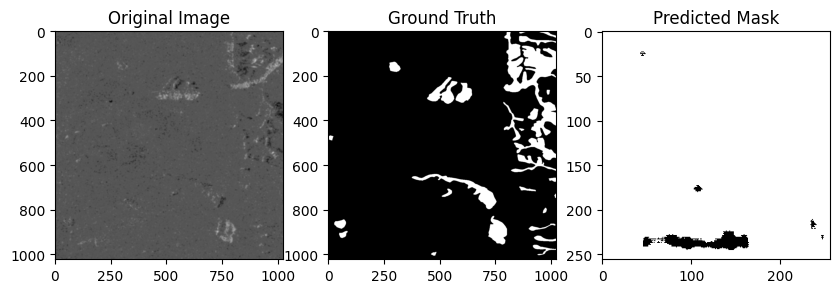

In [25]:
import matplotlib.pyplot as plt

def visualize_segmentation(original_image, ground_truth, predicted_mask):
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Convert the test image and test mask from tensors to numpy arrays for visualization
original_image_np = np.array(test_image)
ground_truth_np = np.array(test_mask)

# Visualize
visualize_segmentation(original_image_np, ground_truth_np, predicted_mask)

## Batch Evaluate

In [10]:
def compute_metrics(output, target, num_classes):
    smooth = 1e-10  # To avoid division by zero

    # Predicted mask
    pred = torch.argmax(output, dim=1)

    iou_per_class = []
    pixel_accuracy_per_class = []

    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).float().sum()  # TP
        union = ((pred == cls) | (target == cls)).float().sum()  # TP + FP + FN
        iou = (intersection + smooth) / (union + smooth)  # IoU

        correct_pixels = (pred == target).float().sum()
        total_pixels = torch.numel(target)
        pixel_accuracy = correct_pixels / total_pixels

        iou_per_class.append(iou.item())
        pixel_accuracy_per_class.append(pixel_accuracy.item())

    # Mean IoU and Mean Pixel Accuracy
    mean_iou = np.mean(iou_per_class)
    mean_pixel_accuracy = np.mean(pixel_accuracy_per_class)

    return mean_iou, mean_pixel_accuracy


In [11]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a smaller size for quick evaluation
    transforms.ToTensor()
])

# Load the OxfordIIITPet dataset (using the segmentation target)
dataset = datasets.OxfordIIITPet(root='./data', split='test', target_types='segmentation', download=True, transform=transform, target_transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Define number of classes (background, pet, pet outline)
num_classes = 3

# Evaluate the model
iou_scores = []
pixel_accuracies = []



with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device).squeeze(1).long()  # Convert masks to long for loss calculation

        # Get model predictions
        outputs = model(images)

        # Resize the outputs to match the mask dimensions (if needed)
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Calculate IoU and Pixel Accuracy
        iou, pixel_accuracy = compute_metrics(outputs, masks, num_classes)

        iou_scores.append(iou)
        pixel_accuracies.append(pixel_accuracy)

# Calculate mean IoU and Pixel Accuracy
mean_iou = np.mean(iou_scores)
mean_pixel_accuracy = np.mean(pixel_accuracies)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

NameError: name 'dataloader' is not defined